In [1]:
# utilities
import re
import numpy as np # linear algebra
import pandas as pd # data processing
import os, json
from glob import glob
import pycountry

# plotting
import seaborn as sns
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt

# nltk
import nltk
from nltk.tokenize import word_tokenize
from nltk.probability import FreqDist

In [2]:
#Stopword List
path_to_txt = '/Volumes/SSD_1/german_stopwords_full.txt'
german_stopword = pd.read_csv(path_to_txt)

In [3]:
# import all files from folder which ends with .json.gz
path_to_json = '/Volumes/SSD_1/ProcessedData'
json_files = glob(os.path.join(path_to_json, '*.json'))
# concat all files to dataframe
df = pd.concat((pd.read_json(f) for f in json_files))

In [4]:
#New Stopword Removal
# preprocess text
def stopword(text):
    
    # stopword removal
    text = [word for word in text.split(' ') if word not in german_stopword]
    text=" ".join(text)

    return text

df['preprocessed_text']= df['preprocessed_text'].apply(stopword)

In [5]:
df.shape

(1456426, 7)

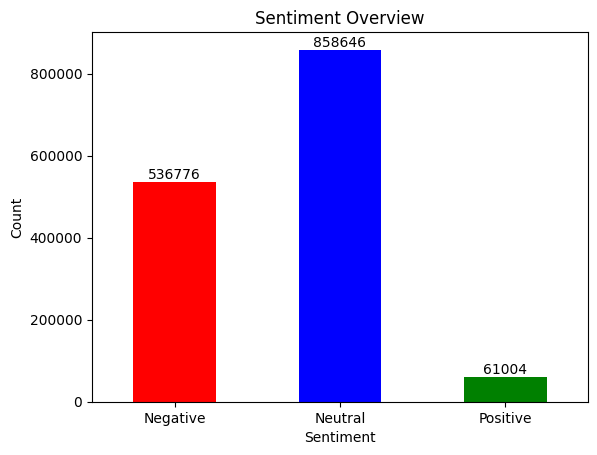

In [6]:
# Plotting the distribution for dataset.
df_subset = df[['text', 'sentiment']]

df_groupby = df_subset.groupby('sentiment').count()

ax = df_groupby.unstack().plot(kind='bar', title='Sentiment Overview',
                               xlabel= 'Sentiment', ylabel = 'Count', 
                               legend=False, color = ['red', 'blue', 'green'])
ax.set_xticklabels(['Negative', 'Neutral', 'Positive'], rotation=0)

# Print the exact number on top of each bar
for p in ax.patches:
    ax.annotate(str(p.get_height()), (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', xytext=(0, 5), textcoords='offset points')

plt.savefig('/Volumes/SSD_1/Output/Year2022/sentiment_overview_bar.jpg',dpi=720)    
plt.show()
    
# Storing data in lists.
text, sentiment = list(df['text']), list(df['sentiment'])

In [7]:
sentiment_ratio = df['sentiment'].value_counts(normalize=True)*100

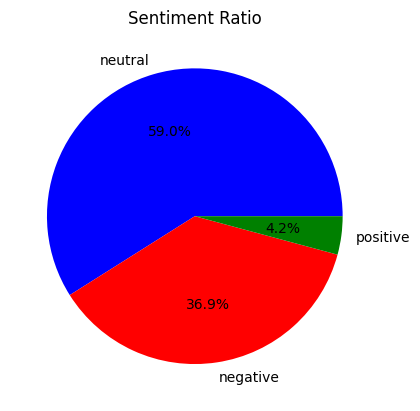

In [8]:
fig, ax = plt.subplots()
ax.pie(sentiment_ratio, labels=['neutral', 'negative', 'positive'], 
       autopct='%1.1f%%',colors=['blue', 'red', 'green'])
plt.title('Sentiment Ratio')
plt.savefig('/Volumes/SSD_1/Output/Year2022/sentiment_overview_pie.jpg',dpi=720)  

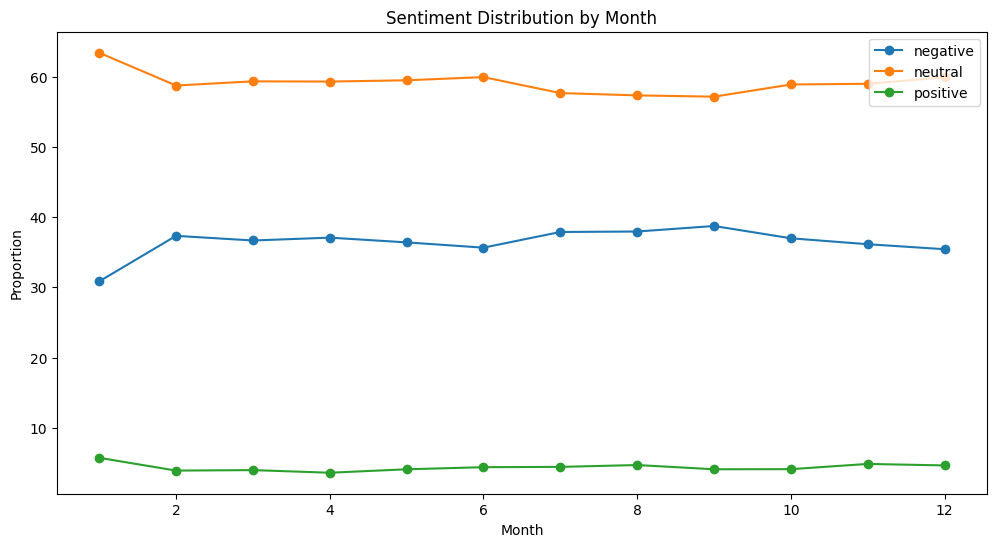

In [9]:
# Convert the "created_at" column to datetime format
df['created_at'] = pd.to_datetime(df['created_at'], unit='ms')

# Extract the month and sentiment values
df['month'] = df['created_at'].dt.month
sentiments = df['sentiment'].unique()

# Group sentiments by month and calculate the proportion
grouped = df.groupby(['month', 'sentiment']).size().unstack().fillna(0)
proportions = grouped.div(grouped.sum(axis=1), axis=0) *100

# Plot the bar chart
#plt.figure(figsize=(20,6))
#proportions.plot(kind='bar', stacked=False, width=0.9, colormap='viridis')
# Plot the line graph
plt.figure(figsize=(12, 6))  # Set the figure size
for sentiment in sentiments:
    plt.plot(proportions.index, proportions[sentiment], marker='o', label=sentiment)

plt.xlabel('Month')
plt.ylabel('Proportion')
plt.title('Sentiment Distribution by Month')
plt.legend(sentiments)
plt.xticks(rotation=0)
plt.savefig('/Volumes/SSD_1/Output/Year2022/sentiment_distribution_year.jpg',dpi=720) 
plt.show()

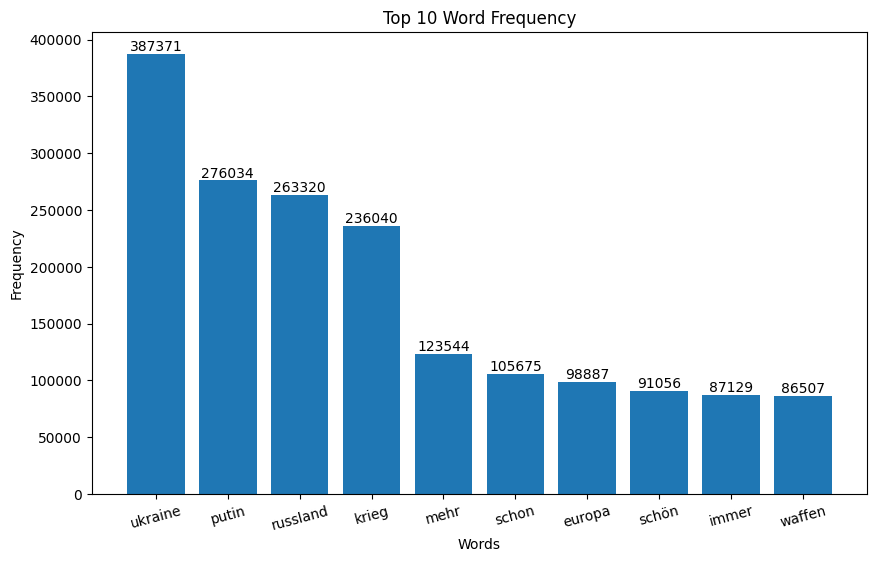

In [10]:
def visualize_word_frequency(df, column):
    # Tokenize the text in the specified column
    tokenized_text = df[column].apply(word_tokenize)

    # Create a list to store all words
    #all_words = [word for text in tokenized_text for word in text]
    all_words = [word for text in tokenized_text for word in text if len(word) >= 4]

    # Calculate word frequency using FreqDist
    freq_dist = FreqDist(all_words)

    # Get the top ten most frequent words
    top_words = freq_dist.most_common(10)

    # Separate words and frequencies for plotting
    words, frequencies = zip(*top_words)

    # Plot the bar chart
    plt.figure(figsize=(10, 6))
    plt.bar(words, frequencies)
    plt.title("Top 10 Word Frequency")
    plt.xlabel("Words")
    plt.ylabel("Frequency")
    plt.xticks(rotation=15)
    
    # Add numbers on top of each bar
    for i, freq in enumerate(frequencies):
        plt.text(i, freq, str(freq), ha='center', va='bottom')
    plt.savefig('/Volumes/SSD_1/Output/Year2022/top10_word_freq_bar.jpg',dpi=720)      
    plt.show()

# Call the function with your data frame and column name
visualize_word_frequency(df, 'preprocessed_text')

In [14]:
# Convert the "created_at" column to datetime format
df['created_at'] = pd.to_datetime(df['created_at'], unit='ms')

# Extract the month from the "created_at" column
df['month'] = df['created_at'].dt.month

# Calculate word frequency for each month
monthly_word_freq = df.groupby('month')['preprocessed_text'].apply(
    lambda x: FreqDist([word for text in x for word in word_tokenize(text)])
)


monthly_word_freq

month                
1      versprechen         37.0
       gegenüber          341.0
       russland          6341.0
       geblieben           44.0
       nato              1979.0
                          ...  
12     stcomzncqjpcve       1.0
       vergeten             1.0
       🇷🇺hirne              1.0
       vertauben            1.0
       sqih                 1.0
Name: preprocessed_text, Length: 11149248, dtype: float64

In [15]:
monthly_word_freq.head()

month             
1      versprechen      37.0
       gegenüber       341.0
       russland       6341.0
       geblieben        44.0
       nato           1979.0
Name: preprocessed_text, dtype: float64

In [ ]:
# Get the top 5 words for each month, excluding NaN values
top_5_words = monthly_word_freq.apply(lambda x: [word for word, _ in x.most_common(5)] if isinstance(x, FreqDist) else [])


# Plot the line chart
plt.figure(figsize=(12, 6))
for month, words in top_5_words.items():
    freqs = [monthly_word_freq[month].get(word, 0) for word in words]
    plt.plot(words, freqs, marker='o', label=f"Month {month}")

plt.xlabel('Words')
plt.ylabel('Frequency')
plt.title('Top 5 Word Frequency by Month')
plt.legend()
plt.xticks(rotation=15)
plt.show()

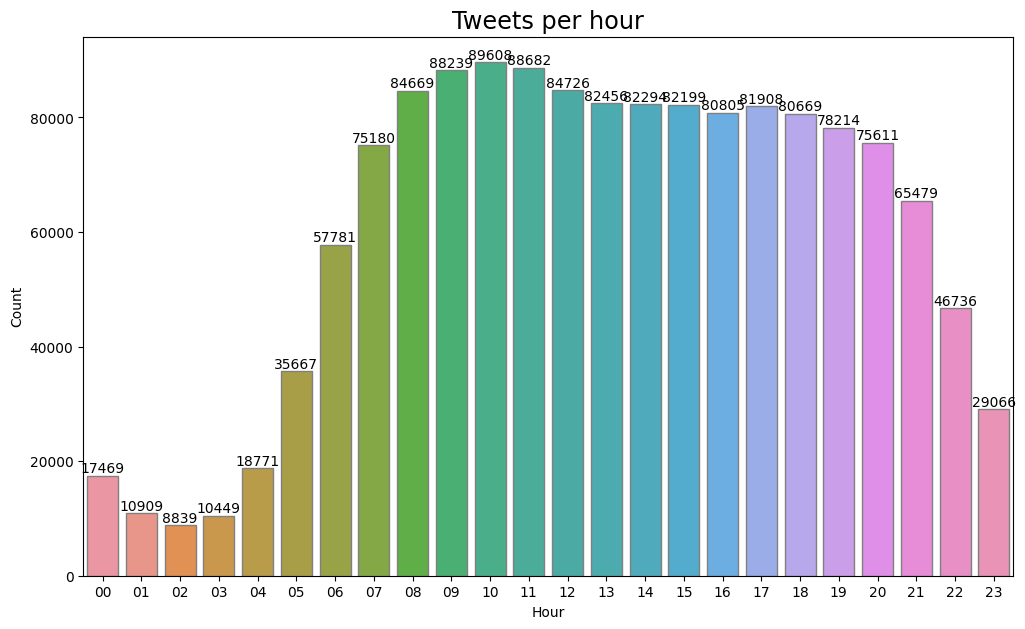

In [19]:
# change to date time format
df['created_at']=pd.to_datetime(df['created_at'])

# tweets per hour
tweets_per_hr = df['created_at'].dt.strftime('%H').value_counts().sort_index().to_frame(name='Count')
tweets_per_hr['Hour']=tweets_per_hr.index

# plot
plt.figure(figsize=(12,7))
ax=sns.barplot(x='Hour', y='Count',data=tweets_per_hr, edgecolor='grey')
ax.bar_label(ax.containers[0])
plt.title('Tweets per hour', size='xx-large')
plt.savefig('/Volumes/SSD_1/Output/Year2022/tweetsPerHour.jpg',dpi=720)  
plt.show()

### WordCloud

**Positive Tweets**

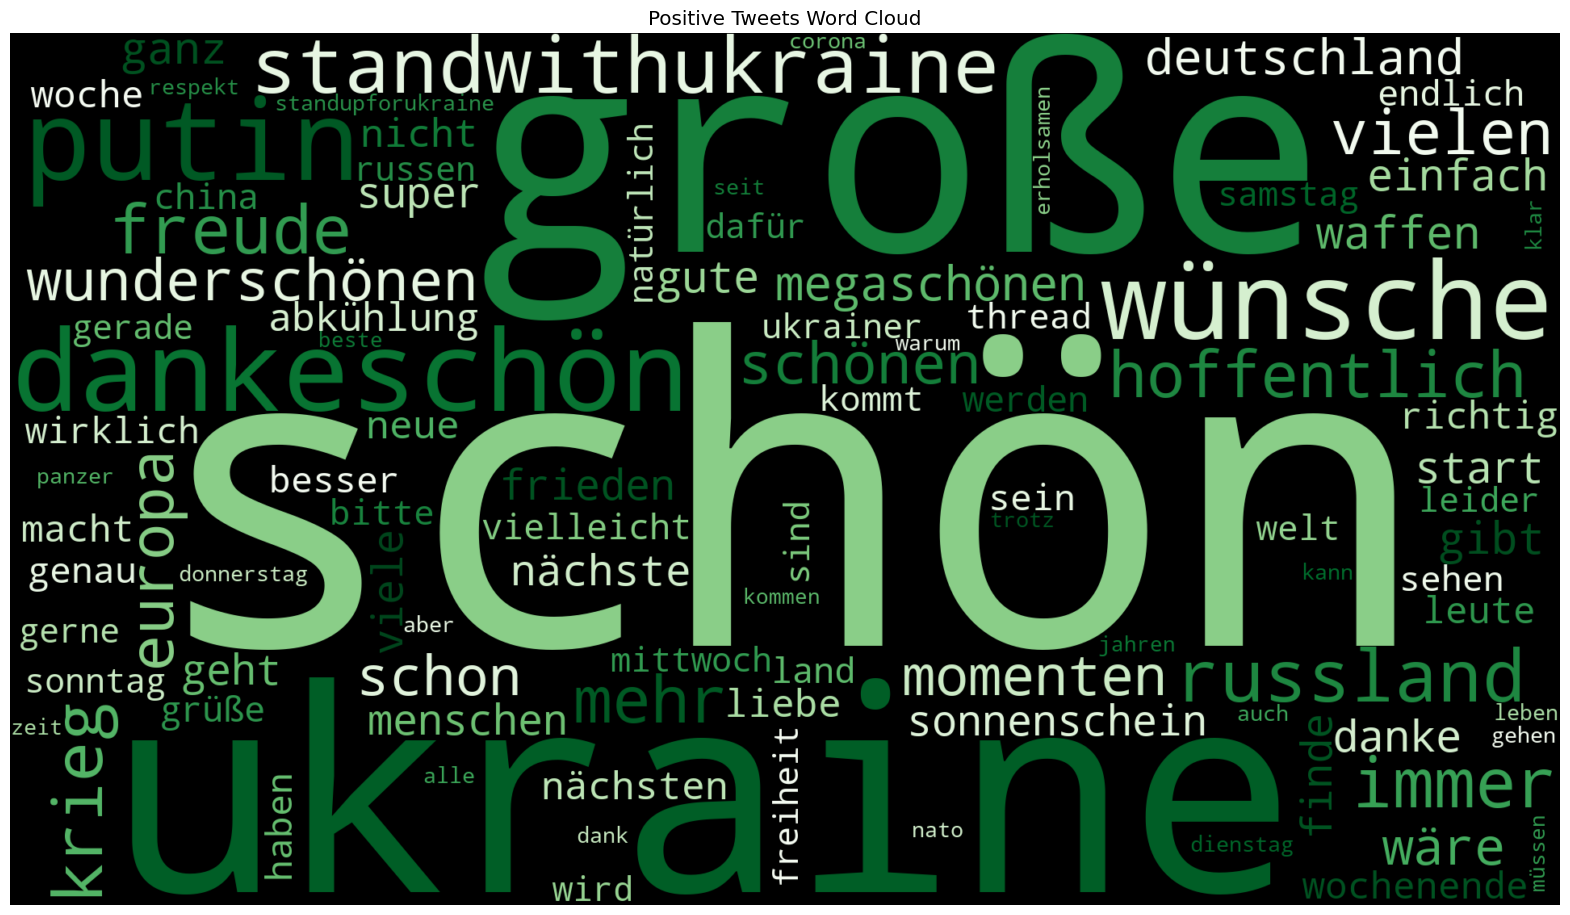

In [20]:
pos_tweets = " ".join(sentiment for sentiment in df[df['sentiment']=='positive']['preprocessed_text'])

# Creating word cloud of positive tweets
word_cloud1 = WordCloud(collocations=False, background_color='black',
                       max_words=100, min_word_length=4, colormap='Greens',
                        width=1920, height=1080).generate(pos_tweets)

# Display the generated Word Cloud
plt.figure(figsize=(20,20))
plt.imshow(word_cloud1, interpolation='bilinear')
plt.axis("off")
plt.title('Positive Tweets Word Cloud', size='x-large')
plt.savefig('/Volumes/SSD_1/Output/Year2022/wordcloud_positive.jpg',dpi=720)

plt.show()

**Negative Tweets**

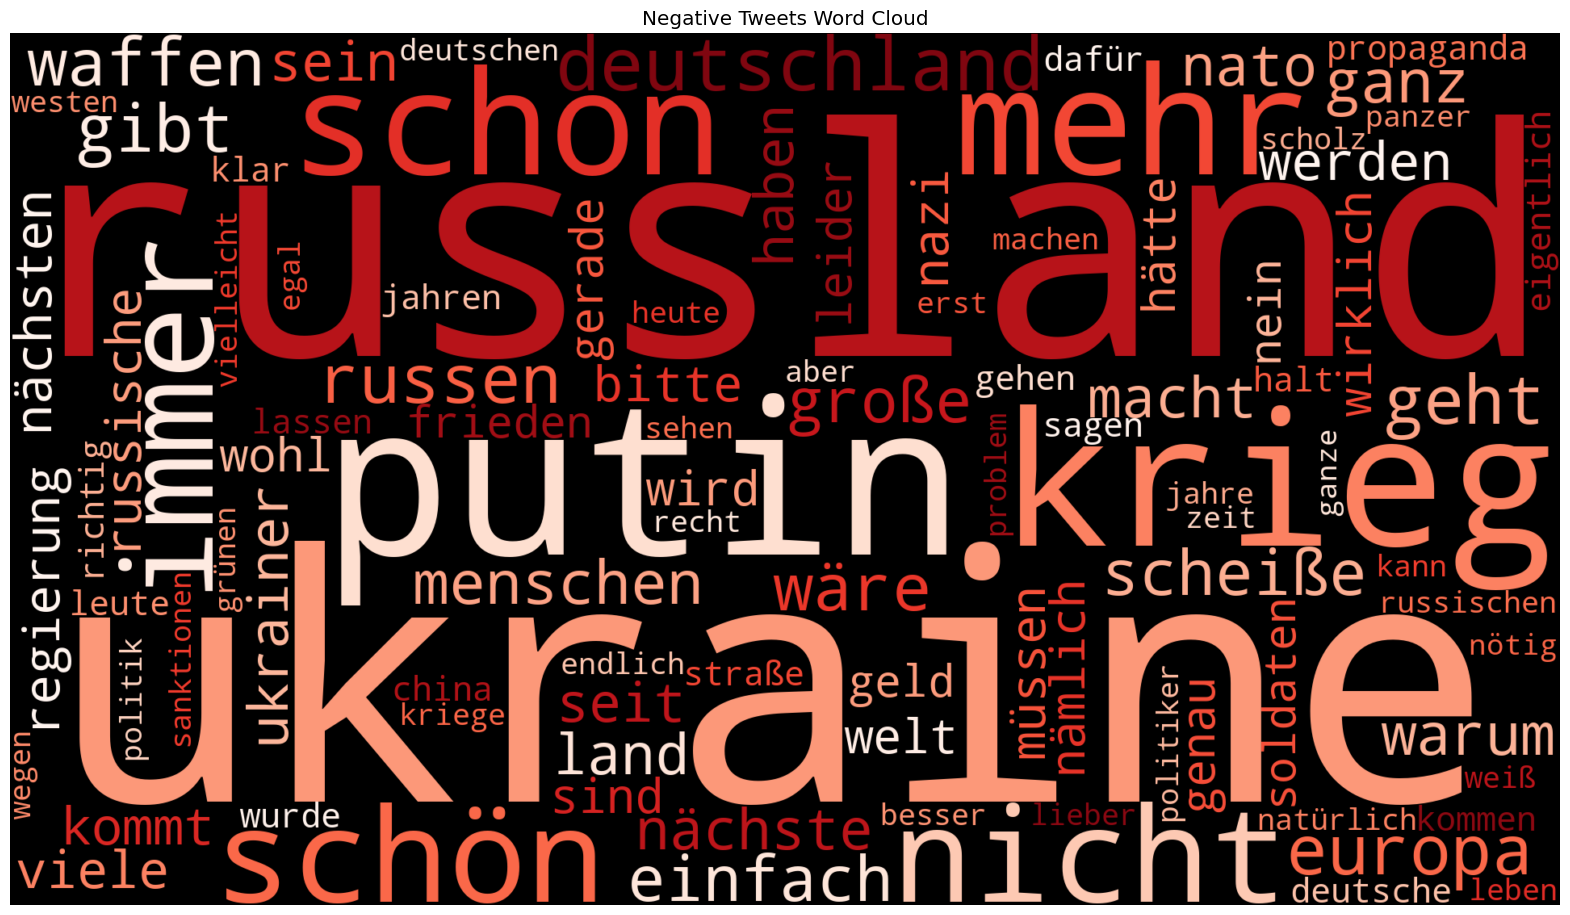

In [21]:
neg_tweets = " ".join(sentiment for sentiment in df[df['sentiment']=='negative']['preprocessed_text'])

# Creating word cloud of positive tweets
word_cloud2 = WordCloud(collocations=False, background_color='black',
                       max_words=100, min_word_length=4, colormap='Reds',
                       width=1920, height=1080).generate(neg_tweets)
#stopwords= german_stopword,
# Display the generated Word Cloud
plt.figure(figsize=(20,20))
plt.imshow(word_cloud2, interpolation='bilinear')
plt.axis("off")
plt.title('Negative Tweets Word Cloud', size='x-large')
plt.savefig('/Volumes/SSD_1/Output/Year2022/wordcloud_negative.jpg',dpi=720)

plt.show()

### Knowledge Graph

In [ ]:
import networkx as nx

# Create an empty graph
graph = nx.Graph()

# Iterate over each row in the DataFrame
for _, row in df.iterrows():
    text = row['preprocessed_text']
    tokens = text.split()  # Split the preprocessed_text into tokens

    # Add edges between adjacent tokens
    for i in range(len(tokens) - 1):
        edge = (tokens[i], tokens[i + 1])
        graph.add_edge(*edge)

# Draw the graph
pos = nx.spring_layout(graph)
nx.draw_networkx(graph, pos, with_labels=True, node_color='lightblue', edge_color='gray', font_size=10, node_size=500)
plt.title("Knowledge Graph - 01")
plt.axis('off')
plt.show()
